<a href="https://colab.research.google.com/github/jithesh9539/Connected_Deep_Networks/blob/main/b)_Deep_Neural_Network_Without_Pytorch_Builtin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3 layer deep neural network for non linear regression without using pytorch builtin layer functionality **

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [9]:
# 3 Dimension non-linear input data

n = 200
d = 3
x = torch.rand(n,d)
weights_true = torch.tensor([[2, 1,-1],[3,0,-1]]).T
bias_true = torch.tensor([[0.5],[0.1]])

y_true = torch.matmul((x ** 2).float() , weights_true.float()) + torch.matmul(x.float() , weights_true.float()) + bias_true.T.float()
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: torch.Size([200, 3]), weights: torch.Size([3, 2]), bias: torch.Size([2, 1]), y: torch.Size([200, 2])


In [10]:
from sklearn.manifold import TSNE
view = TSNE(n_components=2, n_jobs=5).fit_transform(x)
view.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(200, 2)

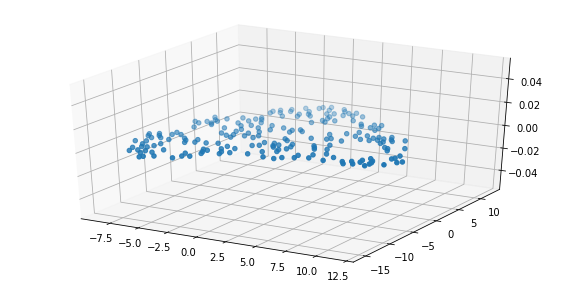

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#y_pred = y_pred.astype('int')
fig = plt.figure(figsize=(10,5))
tsne = fig.add_subplot(111, projection='3d')
tsne.scatter(*zip(*view))
plt.show()

In [12]:
import math
import torch.nn as nn

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient


## Linear layer
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = torch.rand(input_dim, num_hidden) * math.sqrt(2. / input_dim)
    self.bias = torch.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = torch.matmul(x, self.weights) + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = torch.matmul(self.x.T, gradient)
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = torch.matmul(gradient, self.weights.T)
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient


## Adding non-linear activation function reLu
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = torch.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


## Model class
class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

##Calculating the loss 
loss = MSE()
model = TorchModel(d, 4)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(4.6709)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [13]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

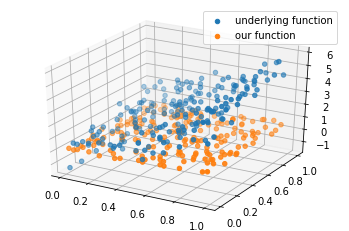

In [14]:
plot_3d(x, y_true, model(x_tensor).detach())

In [15]:
loss = MSE()
model = TorchModel(d, 10)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.01)
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(2.6615)
tensor(2.4795)


In [16]:
from typing import Callable

def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.01, num_epochs=70)

Epoch 0, loss 2.4795398712158203
Epoch 1, loss 2.3386263847351074
Epoch 2, loss 2.2305819988250732
Epoch 3, loss 2.1482114791870117
Epoch 4, loss 2.0854196548461914
Epoch 5, loss 2.037235975265503
Epoch 6, loss 1.9997389316558838
Epoch 7, loss 1.9699255228042603
Epoch 8, loss 1.945551872253418
Epoch 9, loss 1.9249778985977173
Epoch 10, loss 1.9070254564285278
Epoch 11, loss 1.8908624649047852
Epoch 12, loss 1.8759068250656128
Epoch 13, loss 1.8617573976516724
Epoch 14, loss 1.8481380939483643
Epoch 15, loss 1.8348623514175415
Epoch 16, loss 1.8218026161193848
Epoch 17, loss 1.8088736534118652
Epoch 18, loss 1.7960176467895508
Epoch 19, loss 1.7831964492797852
Epoch 20, loss 1.770383596420288
Epoch 21, loss 1.7575619220733643
Epoch 22, loss 1.7447195053100586
Epoch 23, loss 1.7318484783172607
Epoch 24, loss 1.7189433574676514
Epoch 25, loss 1.7060002088546753
Epoch 26, loss 1.693016529083252
Epoch 27, loss 1.679990530014038
Epoch 28, loss 1.6669204235076904
Epoch 29, loss 1.653806209564

In [17]:
def tsne_plot(view, y, y_pred=None):
  fig = plt.figure()
  tsne = fig.add_subplot(111, projection='3d')
  tsne.scatter(view[:, 0], view[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    tsne.scatter(view[:, 0], view[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

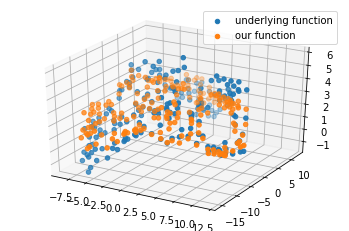

In [18]:
tsne_plot(view, y_true, model(x_tensor).detach())